## LLM Setup

In [3]:
import torch, os, yaml, natsort
from utils.llm import *
from transformers import CLIPImageProcessor
from transformers.utils import logging
logging.set_verbosity_error()

demo_name = "demo"
if demo_name is not None:
    save_path = f"../data/demo_videos/{demo_name}"
else:
    save_path = os.path.join(f"../data/demo_videos/", natsort.natsorted(os.listdir(f"../data/demo_videos/"))[-1])

run_type = f"demo"
demo_config_path = f'../configs/{run_type}.yaml'
demo_configs = yaml.safe_load(open(demo_config_path))
load_exp_path = demo_configs["load_exp_path"]
configs = yaml.safe_load(open(os.path.join(load_exp_path, "run.yaml")))
configs["load_exp_path"] = load_exp_path
configs["cutoff_len"] = 256
configs["max_new_tokens"] = 500
image_processor = CLIPImageProcessor.from_pretrained(configs["use_clip"])
peft = "peft" in configs["load_exp_path"]
device_num = 0
device = f'cuda:{device_num}'
gpu_config = {
    "0": "5GiB",
    "1": "28GiB"
}
tokenizer_path, model_path, new_tokens, no_split_module_classes = get_model_details(configs["model_type"])
model = load_mllm(configs, tokenizer_path, model_path, new_tokens, no_split_module_classes, peft, device, gpu_config, exp_id=None)
tokenizer = model.tokenizer
model.eval()

Loading trained tokenizer!
Loading trained LLM!


Loading checkpoint shards: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
/home/user/.conda/envs/octopi2/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:796: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loaded LLM and tokenizer!
0 tokens added to tokenizer.
Tokenizer BOS: None, EOS: <|im_end|>, Pad: <|endoftext|>
Loaded multimodal LLM!
Loaded tactile encoder with learnable prompts!
Loaded plain tactile adapter!
Loaded dotted tactile adapter!
Loaded projection module!


MultimodalLLMForCausalLM(
  (encoder): CLIPVisionEncoder(
    (model): CLIPVisionModel(
      (vision_model): PromptLearningCLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(257, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): PromptLearningCLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x PromptLearningCLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=

## Video Processing

In [4]:
import matplotlib.pyplot as plt
from utils.dataset import get_frames
from torchvision import transforms
import natsort
import cv2 as cv
import numpy as np
import random


transforms_list = [
    transforms.ToTensor(),
    transforms.Resize(configs["frame_size"], interpolation=3),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    ),
    transforms.CenterCrop(configs["frame_size"])
]
image_transforms = transforms.Compose(transforms_list)
inverse_transforms_list = [
    transforms.Normalize(
        mean=[-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711],
        std=[1/0.26862954, 1/0.26130258, 1/0.27577711]
    ),
]
inverse_transforms = transforms.Compose(inverse_transforms_list)


def plot_frames_inline(sample_path, image_transforms):
    plt.rcParams['figure.dpi'] = 200
    rows = 1
    columns = 10
    f, arr = plt.subplots(rows, columns)
    # plt.suptitle(sample)
    image_tensors = inverse_transforms(get_frames(sample_path, None, image_transforms, frame_size=configs["frame_size"], train=False))
    padding_size = rows * columns - image_tensors.shape[0]
    if padding_size > 0:
        padding = torch.stack([image_tensors[-1]] * padding_size, dim=0)
        image_tensors = torch.cat([image_tensors, padding], dim=0)
    for i in range(len(image_tensors)):
        arr[int(i%columns)].axis('off')
        arr[int(i%columns)].imshow(image_tensors[i].cpu().numpy().transpose(1,2,0))
    plt.tight_layout()
    plt.show()


def extract_span(sample_video_path, sample_frame_path, threshold, min_len, max_len, top_frame_num):
    def get_frames(sample_video_path, sample_frame_path):
        vidcap = cv.VideoCapture(sample_video_path)
        success, image = vidcap.read()
        count = 0
        while success:
            cv.imwrite(os.path.join(sample_frame_path, f"{count}.jpg"), image)     # save frame as JPEG file      
            success, image = vidcap.read()
            # print('Read a new frame: ', success)
            count += 1

    def find_longest_spans(arr):
        # Find the maximum length by traversing the array
        max_count = 0
        second_max_count = 0
        span, indices, max_indices, second_max_indices = [], [], [], []
        count = 0
        for i in range(1, len(arr)):
            # Check if the current element is equal to previous element +1
            frame_id = int(arr[i].split("/")[-1].split(".")[0])
            prev_frame_id = int(arr[i-1].split("/")[-1].split(".")[0])
            if frame_id == prev_frame_id + 1:
                if count == 0:
                    span.append(arr[i-1])
                    count += 1
                    # indices.append(i-1)
                count += 1
                span.append(arr[i])
                # indices.append(i)
            # Reset the count
            else:
                # Update the maximum
                if count > max_count:
                    max_count = count
                    max_span = span
                    # max_indices = indices
                elif count > second_max_count:
                    second_max_count = count
                    second_max_span = span
                    # second_max_indices = indices
                span = []
                count = 0
                # indices = []
        try:
            return max_span, max_indices, second_max_span, second_max_indices
        except UnboundLocalError:
            pass
        try:
            return max_span, max_indices, None, None
        except UnboundLocalError:
            # If there is no continuous span, get a random frame
            idx = random.randrange(0, len(arr))
            max_span = [arr[idx]]
            max_indices = [idx]
            return max_span, max_indices, None, None
            
    get_frames(sample_video_path, sample_frame_path)
    sample_frames = natsort.natsorted(os.path.join(sample_frame_path, i) for i in os.listdir(sample_frame_path))
    # 1) Get a certain number of frames above a certain change threshold
    prev_frame_img = cv.imread(sample_frames[0])
    prev_frame_gray = cv.cvtColor(prev_frame_img, cv.COLOR_BGR2GRAY)
    all_diffs = []
    for frame in sample_frames[1:]:
        # frame_id = int(frame.split("/")[-1].split(".")[0])
        frame_img = cv.imread(frame)
        frame_gray = cv.cvtColor(frame_img, cv.COLOR_BGR2GRAY)
        try:
            frame_diff = cv.absdiff(prev_frame_gray, frame_gray)
        except cv.error:
            break
        _, thresh = cv.threshold(frame_diff, threshold, 255, cv.THRESH_BINARY)
        total_diff = np.sum(thresh)
        all_diffs.append((frame, total_diff))
        prev_frame_gray = frame_gray
    all_diffs = sorted(all_diffs, key=lambda t: t[1], reverse=True)[:top_frame_num]
    all_diffs = sorted(all_diffs, key=lambda t: t[0])
    all_diffs = [i[0] for i in all_diffs]
    # 2) Get continuous spans
    max_span, max_indices, second_max_span, second_max_indices = find_longest_spans(all_diffs)
    if second_max_indices is not None:
        final_span = natsort.natsorted(max_span + second_max_span)
        final_indices = natsort.natsorted(max_indices + second_max_indices)
    else:
        final_span = max_span
        final_indices = max_indices
    if len(final_span) > max_len:
        final_span = final_span[:max_len]
    # 3) Remove frames that are not in the final span
    for frame in sample_frames:
        if frame not in final_span:
            os.remove(frame)

## Query Processing

In [5]:
def get_tactile_videos(save_path):
    tactile_videos = {}
    for sample in natsort.natsorted(os.listdir(save_path)):
        sample_path = os.path.join(save_path, sample)
        if os.path.isdir(sample_path):
            if "item.mov" in os.listdir(sample_path):
                # One object part only
                sample_video_path = os.path.join(sample_path, "item.mov")
                sample_frame_path = os.path.join(sample_path, "frames")
                if not os.path.exists(sample_frame_path):
                    os.makedirs(sample_frame_path, exist_ok=True)
                    extract_span(sample_video_path, sample_frame_path, threshold=0, min_len=5, max_len=10, top_frame_num=50)
                tactile_videos[int(sample)] = os.path.join(os.path.join(save_path, sample), "frames")
            else:
                # Multiple object parts
                tactile_videos[int(sample)] = []
                for part in natsort.natsorted(os.listdir(sample_path)):
                    part_path = os.path.join(sample_path, part)
                    part_video_path = os.path.join(part_path, "item.mov")
                    part_frame_path = os.path.join(part_path, "frames")
                    if not os.path.exists(part_frame_path):
                        os.makedirs(part_frame_path, exist_ok=True)
                        extract_span(part_video_path, part_frame_path, threshold=0, min_len=5, max_len=10, top_frame_num=50)
                    tactile_videos[int(sample)].append(part_frame_path)
    return tactile_videos
    

def get_tactile_embeds(save_path, user_input):
    user_input = user_input.strip()
    if "$dr" in user_input:
        describe = True
        rank = True
    elif "$d" in user_input:
        describe = True
        rank = False
    elif "$r" in user_input:
        describe = False
        rank = True
    video_indices = [int(i) for i in user_input.split("(")[-1][:-1].split(",")]
    tactile_videos = get_tactile_videos(save_path)
    tactile_paths = [tactile_videos[i] for i in video_indices]
    tactile_paths_flattened = []
    num_objects = len(tactile_paths)
    if num_objects == 1:
        task_prompt = ["Describe the object in the following tactile video(s).\n\n"]
    elif describe and rank:
        task_prompt = ["Describe the objects in the following tactile videos and rank them in decreasing hardness and roughness.\n\n"]
    elif describe:
        task_prompt = ["Describe the objects in the following tactile videos.\n\n"]
    elif rank:
        task_prompt = ["Rank the objects in the following tactile videos in decreasing hardness and roughness.\n\n"]
    for i in range(num_objects):
        if type(tactile_paths[i]) == str:
            # One object part only
            task_prompt.append(f"Object {video_indices[i]}: ")
            task_prompt.append("<tact_tokens>")
            tactile_paths_flattened.append(tactile_paths[i])
        else:
            # Multiple object parts
            task_prompt.append(f"Object {video_indices[i]}\n")
            num_parts = len(tactile_paths[i])
            for p in range(num_parts):
                task_prompt.append(f"Part {video_indices[i]}.{p+1}: ")
                task_prompt.append("<tact_tokens>")
                tactile_paths_flattened.append(tactile_paths[i][p])
                if p != num_parts - 1:
                    task_prompt.append("\n")
        if i != num_objects - 1:
            task_prompt.append("\n\n")
    with torch.no_grad():
        question = task_prompt.copy()
        tactile_count = 0
        for q in range(len(question)):
            if question[q] == "<tact_tokens>":
                # NOTE: Assume no dotted samples
                tactile_path = tactile_paths_flattened[tactile_count]
                question[q] = f"[{tactile_path}]"
                tactile_count += 1
        joined_question = "".join(question)
        messages = [
            {"role": "user", "content": joined_question}
        ]
        question_template = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        question_embeds = process_user_input(question_template, image_processor, model, tokenizer, device, new_tokens, configs["frame_size"], image_transforms)
        return question_embeds, question, tactile_paths_flattened
    

def get_question_embeds(user_input, configs):
    if "$" in user_input:
        question_embeds, question, tactile_paths_flattened = get_tactile_embeds(save_path, user_input)
        print(f"# USER: {question[0]}\n", flush=True)
        tactile_count = 0
        for chunk in question[1:]:
            if "[" in chunk or "{" in chunk:
                plot_frames_inline(tactile_paths_flattened[tactile_count], image_transforms)
                tactile_count += 1
            else:
                print(chunk, flush=True)
    else:
        print(f"# USER: {user_input}\n")
        messages = [
            {"role": "user", "content": user_input}
        ]
        question_template = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        question_embeds = process_user_input(question_template, image_processor, model, tokenizer, device, new_tokens, configs["frame_size"], image_transforms)
    return question_embeds

## Interact

# USER: hi

# ASSISTANT: Hello! How can I assist you today?<|im_end|>

# USER: Describe the objects in the following tactile videos and rank them in decreasing hardness and roughness.



Object 1: 


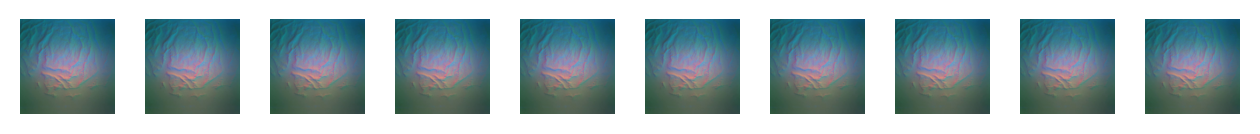




Object 2: 


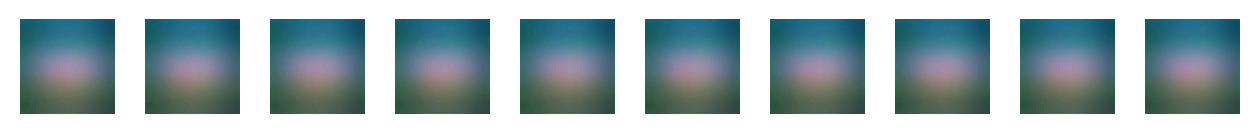




Object 3: 


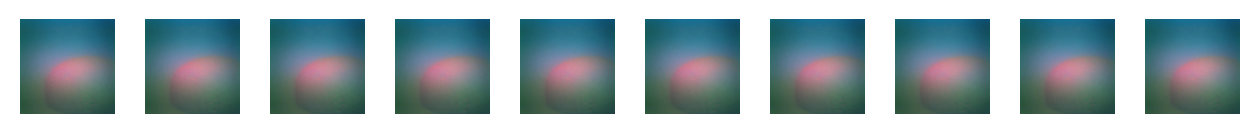




Object 5

Part 5.1: 


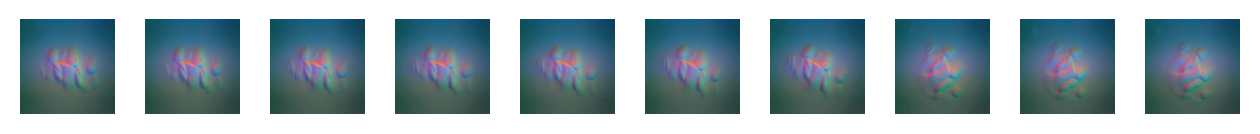



Part 5.2: 


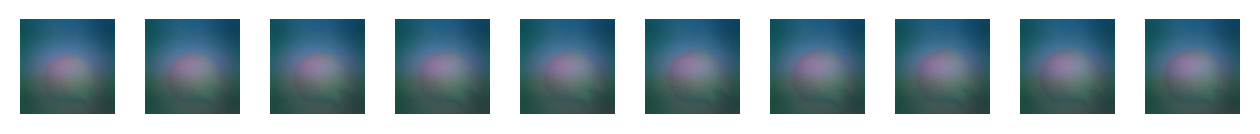

# ASSISTANT: Object 1: textured, wrinkled, soft, mushy.

Object 2: slightly textured, squishy, slightly smooth, fluffy.

Object 3: firm, glossy, smooth.

Object 5.1: textured, hard, seam-lined, grippy.

Object 5.2: glossy, smooth, hard.

Object parts ranked in decreasing hardness: 3, 5.2, 5.1, 1, 2
Object parts ranked in decreasing roughness: 5.1, 1, 2, 5.2, 3<|im_end|>

# USER: Note: The objects with parts mean they have distinct textures in different parts of the object.\n\nUsing the descriptions and rankings of all object parts, which object is more likely to be a baseball?

# ASSISTANT: Based on the descriptions and rankings provided, the object that is more likely to be a baseball is **Object 5**. Here's the reasoning:

1. **Object 3**: The description "firm, glossy, smooth" does not align well with the characteristics of a baseball, which typically has a textured surface for grip.

2. **Object 1**: The description "soft, mushy" clearly does not match a baseball.

3. **Object 2**:

In [ ]:
from IPython.display import clear_output

with torch.no_grad():
    user_input = input(f"USER: ")
    while user_input == "restart":
        clear_output(wait=True)
        user_input = input(f"USER: ")
    if "$" in user_input:
        question_embeds, question, tactile_paths_flattened = get_tactile_embeds(save_path, user_input)
        print(f"# USER: {question[0]}\n", flush=True)
        tactile_count = 0
        for chunk in question[1:]:
            if "[" in chunk or "{" in chunk:
                plot_frames_inline(tactile_paths_flattened[tactile_count], image_transforms)
                tactile_count += 1
            else:
                print(chunk, flush=True)
    else:
        print(f"# USER: {user_input}\n", flush=True)
        messages = [
            {"role": "user", "content": user_input}
        ]
        question_template = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        question_embeds = process_user_input(question_template, image_processor, model, tokenizer, device, new_tokens, configs["frame_size"], image_transforms)
    input_embeds = question_embeds
    prev_embeds = input_embeds.detach().clone()
    generation_tokens = model.llm.generate(inputs_embeds=input_embeds, max_new_tokens=configs["max_new_tokens"], num_beams=1, do_sample=False, temperature=None, top_p=None, top_k=None)
    generation = tokenizer.decode(generation_tokens[0]) # https://huggingface.co/docs/transformers/main/llm_tutorial
    # Add generation embeddings to prev_embeds
    generation_tokens = torch.unsqueeze(encode_text(tokenizer, generation), 0).to(device)
    generation_embeds = model.llm.get_input_embeddings()(generation_tokens)
    prev_embeds = torch.cat([prev_embeds, generation_embeds], dim=1)
    print(f"# ASSISTANT: {generation}\n", flush=True)
    user_input = input("USER: ")

    while user_input.strip() != "exit":
        if user_input == "restart":
            clear_output(wait=True)
            user_input = input(f"USER: ")
        elif len(user_input) == 0:
            user_input = input(f"USER: ")
        else:
            question_embeds = get_question_embeds(user_input, configs)
            input_embeds = torch.cat((prev_embeds, question_embeds), dim=1)
            prev_embeds = input_embeds.detach().clone()
            generation_tokens = model.llm.generate(inputs_embeds=input_embeds, max_new_tokens=configs["max_new_tokens"], num_beams=1, do_sample=False, temperature=None, top_p=None, top_k=None)
            generation = tokenizer.decode(generation_tokens[0]) # https://huggingface.co/docs/transformers/main/llm_tutorial
            # Add generation embeddings to prev_embeds
            generation_tokens = torch.unsqueeze(encode_text(tokenizer, generation), 0).to(device)
            generation_embeds = model.llm.get_input_embeddings()(generation_tokens)
            prev_embeds = torch.cat([prev_embeds, generation_embeds], dim=1)
            print(f"# ASSISTANT: {generation}\n", flush=True)
            user_input = input("USER: ")